In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: van Breukelen, Sterre (1013957)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

First the nodes and layers were increased. Different values for nodes were tried, double/triple/quadruple the number of nodes from the bottom up. Quadruple with four layers works best.  Different activations were tried, relu performed better then elu and selu. Sigmoid performed better then softmax and softplus. Having the last layer with activation sigmoid worked best then any other combo. Lastly, I finetuned the epochs to reduce overfitting, the model still overfits slightly  (length: 482)



Max val score: 73.90%


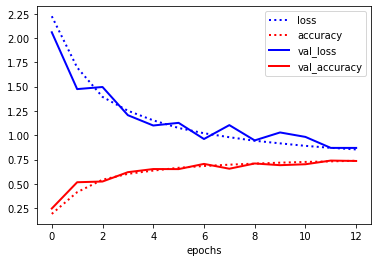

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_150 (Dense)            (None, 640)               1966720   
_________________________________________________________________
dense_151 (Dense)            (None, 160)               102560    
_________________________________________________________________
dense_152 (Dense)            (None, 40)                6440      
_________________________________________________________________
dense_153 (Dense)            (None, 10)                410       
Total params: 2,076,130
Trainable params: 2,076,130
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))

#     73 with overfitting
    model.add(layers.Dense(640, activation='relu'))
    model.add(layers.Dense(160, activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))

    
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



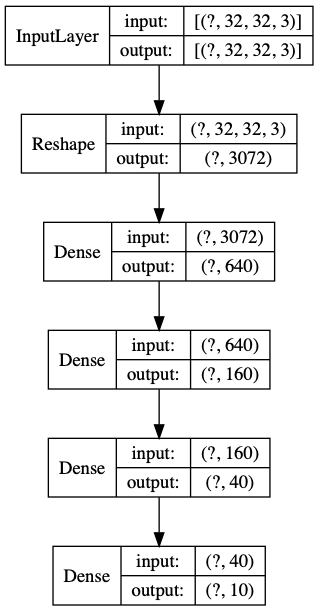

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

I greyscaled X_training and X_val and I changed the Reshape to be on dimention 32x32x1, as this is the new shape the images have come in. The model performs slightly better, because the color of the images is not taken into account when classifying the numbers, as color isn't important in the classification. However, the accuracy difference between 1.2 and 1.1 is minimal.  (length: 376)



Max val score: 77.48%


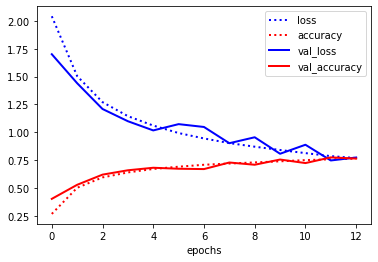

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_158 (Dense)            (None, 640)               656000    
_________________________________________________________________
dense_159 (Dense)            (None, 160)               102560    
_________________________________________________________________
dense_160 (Dense)            (None, 40)                6440      
_________________________________________________________________
dense_161 (Dense)            (None, 10)                410       
Total params: 765,410
Trainable params: 765,410
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

I tried kernel, bias and activity regularizers for l1 and l2, for values from 1 to 0.0001. The one combo chosen was the one with the highest accuracy and the lowest overfitting. I tried RMSprop,SGD, Adadelta, Adam, Adamax, and Nada optimizers with the values of 1 to 0.0001 as learning rate. Nadam optimizer performed the best out of all the others with learning rate 0.0001. Lastly I finetuned the epochs and the batch size. The model starts to overfit at more epochs.   (length: 472)



Max val score: 77.36%


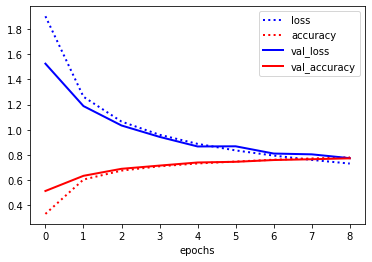

def build_model_1_3():
    model = models.Sequential()
   
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))

    model.add(layers.Dense(640, 
                           activation='relu', 
                            bias_regularizer=regularizers.l2(0.1), 
                          ))
    
    model.add(layers.Dense(160,
                           activation='relu',
                           bias_regularizer=regularizers.l2(0.01), 
                           
                          ))
    
    
    model.add(layers.Dense(40, 
                           activation='relu',
                           bias_regularizer=regularizers.l2(0.001), 
                           
                          ))
    
    model.add(layers.Dense(10, 
                           activation='sigmoid',
                           bias_regularizer=regularizers.l2(0.0001), 
                           activity_regularizer=regularizers.l2(0.0005)
#                            
                     

In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Several convolutional layers were tried in several combos, like Conv2D, Cropping2D, and UpSampling2D. Conv2D layers were added with increasing value of filters to learn the patterns on different levels of abstraction. MaxPooling was added inbetween the conv2D layers to reduce the resolution and increase the translation. More conv2D layers were added, in groups of one, two and three and groups of two gave the best accuracy. The same was tried with MaxPooling and one layer gave the best accuracy. Dropout as added in several different places with several different values. The combo chosen gave the best accuracy. A layer of UpSampling2D in its current position increased the accuracy. The other types of layers decreased the accuracy. Lastly the hyperparameters were tuned  (length: 778)



Max val score: 94.37%


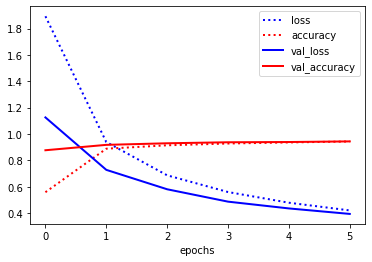

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

def build_model_2_1():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',  input_shape=(32, 32, 1) ))  
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', ))
    
    model.add(layers.UpSampling2D(size=(1, 1), data_format=None, interpolation='nearest') )
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',  ))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',  ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.2))   
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',   ))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',  ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatt

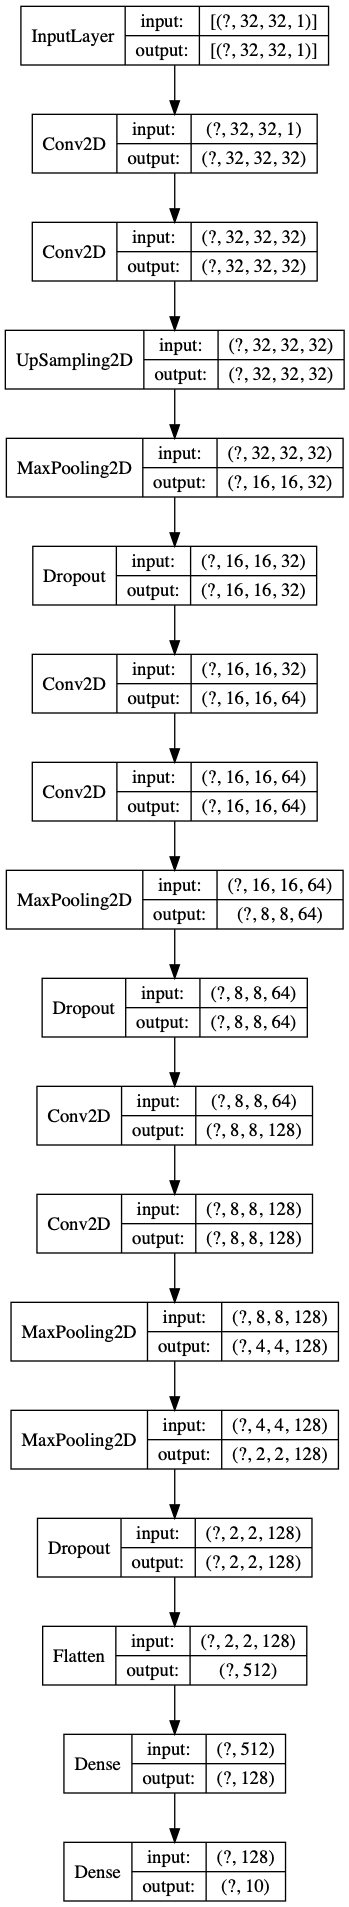

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Several setting for imageDataGenerator were tried, but most didn't help the accuracy or overfitting. The rotation range, gave the best reduction in overfitting when the value was low, so not over 0.10 The accuracy went down when using horizontal and vertical flip. Also with Brightness_range, the shifts, and zoom range. When using shear_range the overfitting went up slightly. Overal the accuracy hasn't increased, but there is a lot less overfitting.  (length: 454)



Max val score: 94.39%


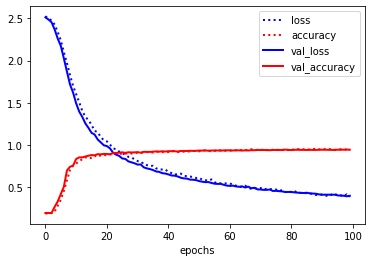


train_datagen = ImageDataGenerator(
    rotation_range=0.10, 
)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

50 images were compaired, only fifteen were printed in the final version for readability The classes that are often confused are 5 and 3, 7 and 1, 1 and 4. 5 and 3 is most likely confused because the lower halves are the same. 7 and 1, and 1 and 4 probably gets confused, because all numbers have straight lines. I visualize the misclassifications of class 3. A lot of missclassification is caused by noisiness and blurriness, so part of the numberr gets lost and it gets missclassified. Another missclassification is caused by rotation. It then gets confused for a 4 if it is rotated to the left and as a 2 if rotated to the right Also there are missclassification when the 3 is denoted slightly different. For instance, if the upper half isn't a half circle but straight lines, it gets confused for a 5.  (length: 807)

Test score: [0.3891709098397863, 0.9439017]


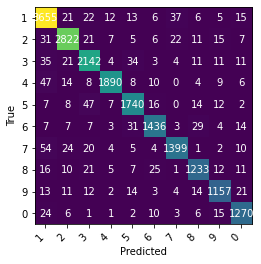

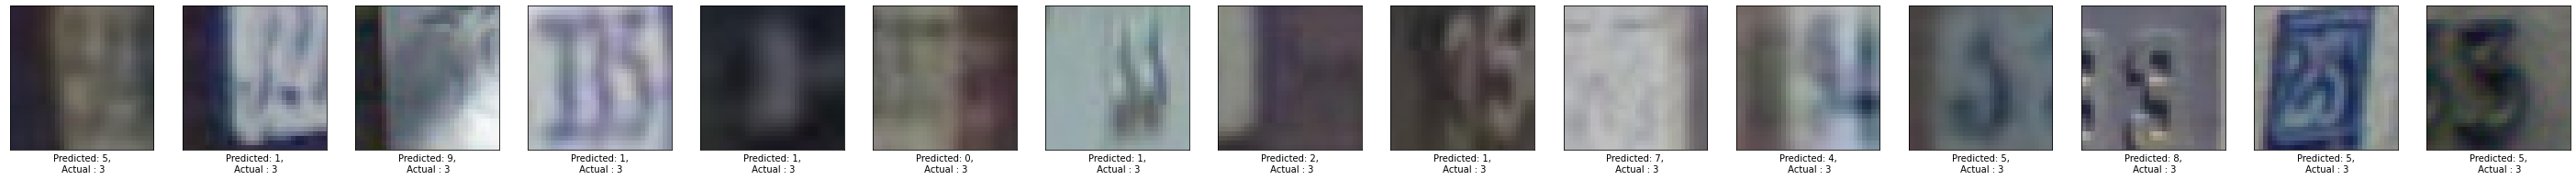

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

The most interesting layers to view are the conv2d layers. After the third layer, the layers become more abstract and there isn't much infrmation to be gathered. In the first two layers there is various edge detecting. Such as the edges around th eight and five. Layer 3 already shws amore abstract images, but the 8 is often still recognisable. After that the images beccome more abstract, however layer 4 still shows a pattern of three lines. In layer 5 this pattern is no longer vissable and the images seem to not have a clear pattern and are very abstact. Layer 6, are only a scattering of dots, so it seemms like the model is no longer learning anything useful  (length: 668)



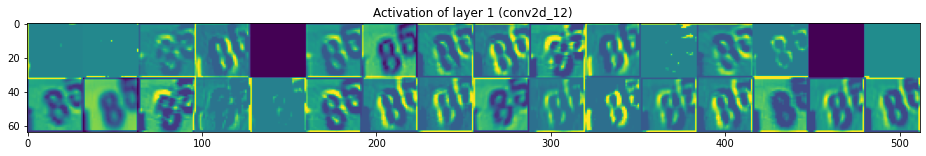

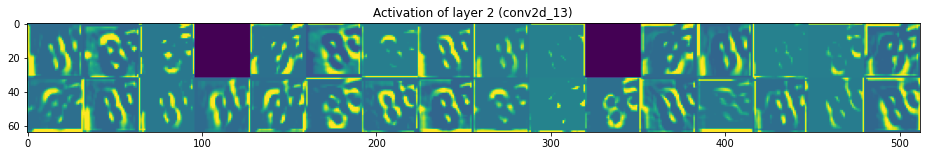

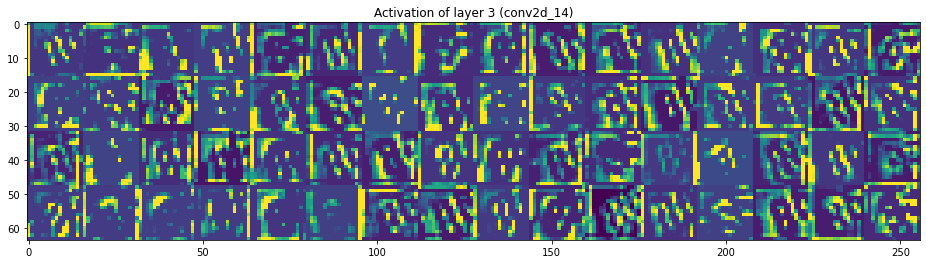

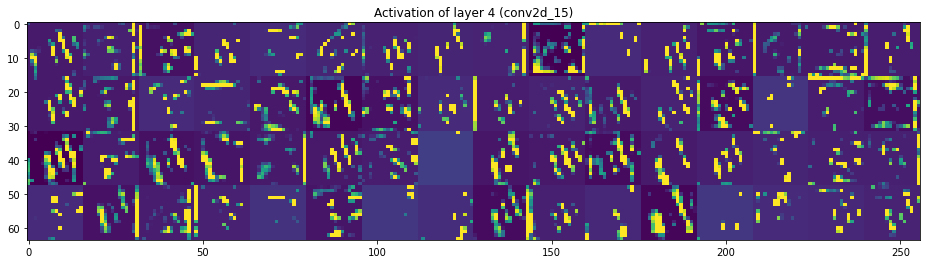

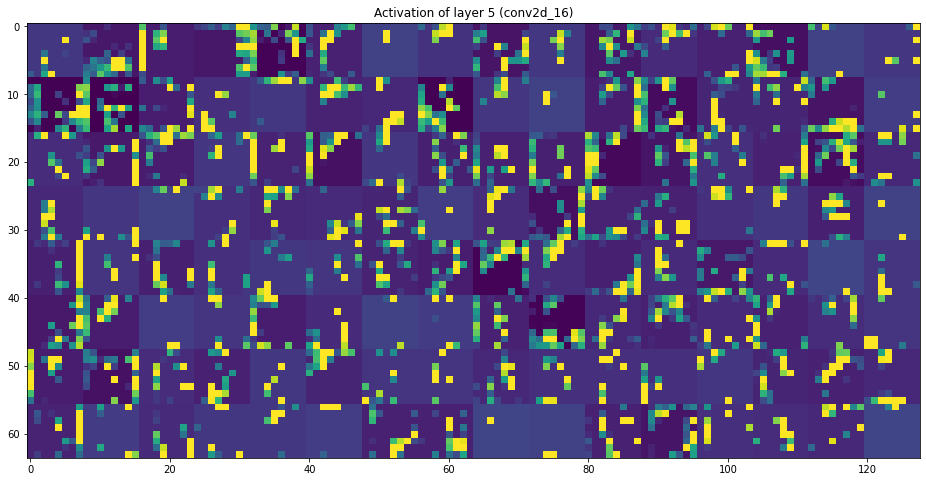

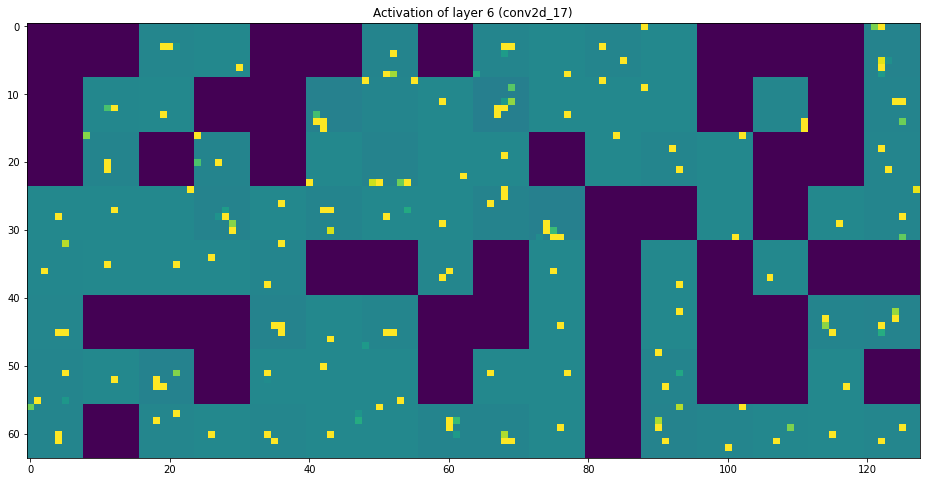

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

Predicted: 8


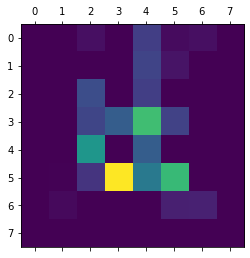

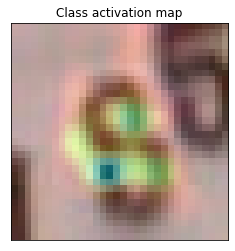

def plot_activation_map():
    #needed to be added to run k.gradient
    tf.compat.v1.disable_eager_execution()  

    #load the model from 2.2
    model =  load_model_from_file(base_dir=base_dir, name="model_2_2")
    #we need a graph to get solve of a error tat only occured when you first run the cell
    graph = tf.compat.v1.get_default_graph()
    
    #get img and modify it so it can be used
    x = X_test[0]
    x = np.expand_dims(x, axis=0)
    x = rgb2gray(x)
    
    output = model.output
    last_conv_layer = model.get_layer('conv2d_17')
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    pooled_grads_value, conv_layer_output_value = iterate([x])

    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    #get prediction usi

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

For freezing several things were tried. The entire conv_base was freezed, up to the last three blocks were unfrozen. Unfreezing the last blocks worked best, however, there wasn't a difference seen between unfreezing the last one, two or three blocks, so only the last block was not freezed. Different optimizers were tried and RMSprop with default learning rate performed best. The accuracy of the model is arround 60%, however there is some overfitting.  (length: 456)



Max val score: 59.35%


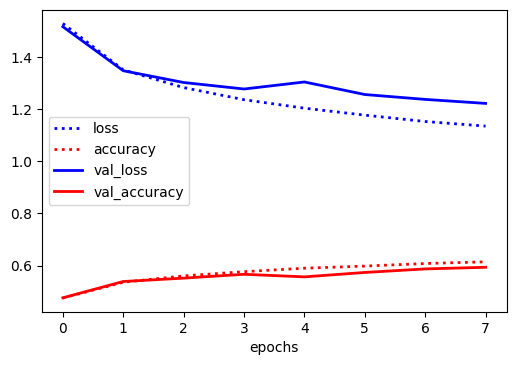

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_39 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________
None
def build_model_4_1():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model = models.Sequential()
    model.add(conv_base)

    
    for layer in conv_base.layers:
        if layer.name

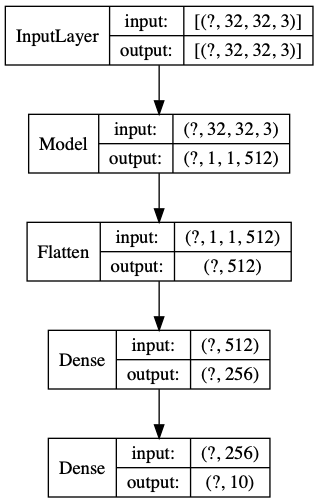

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

Some regressors were tried. Linear gave an accuracy of about 30%, Ridge and lasso were worse. RandomForest and GradientBoosting took a about an hour to run, and had an accuracy of about 32-37 SVR, gave a similair accuracy. Yet it took over three hours to run, so it was decided to continue with linear, as it gives a similair accuracy but quicker. Due to time restrictions, the accuracy I settled for was 34 for training data and 33 for the test data. This is not better then the other models. (length: 494)

Pipeline(steps=[('regressor', LinearRegression())])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """

    model = load_model_from_file(base_dir=base_dir, name="model_4_1") 
    conv_base =  model.get_layer('vgg16')

    
    embed_train = conv_base.predict(X_train)
    embed_test = conv_base.predict(X_test)
  

    store_embedding(embed_train, 'train')
    store_embedding(embed_test, 'test')

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Ru

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 19.84 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
